In [2]:
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#clean data module
import clean_data
import time
import statistics as st

#pca functions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#clustering functions
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist


#supervised models functions
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score


%matplotlib inline
#for reproducible results across multiple function calls
SEED = 42

In [3]:
azdias_selected = pd.read_csv('azdias_selected.csv')
customers_selected = pd.read_csv('customers_selected.csv')

# PCA

In [4]:
azdias_pca = PCA(random_state = SEED)
azdias_pc = azdias_pca.fit_transform(azdias_selected)

In [6]:
def pca_df(data, var_per):
    """
    Inputs:  data - data frame 
             var_per - float in [0,1]
    Returns: pca class of data
             data frame with PC that explain var_per% of the variance of data
    """
    #instantiate PCA 
    pca = PCA(random_state=SEED)
    data_pca = pca.fit_transform(data)
    cumm_var = pca.explained_variance_ratio_.cumsum()
    #number of columns that explain var_per% of variance
    n = np.argmax(cumm_var >= var_per)
    #names of columns in output dataframe
    col_names = ['PC' + str(k) for k in range(1, data_pca.shape[1]+1)]
    #drop cols not necessary to explain % of variance desired
    data_PC = pd.DataFrame(data_pca, columns = col_names).iloc[:,:(n-1)]
    
    return pca, data_PC

We will work with the 22 first principal components which explain 90% of the variance in the azdias dataset.

In [8]:
azdias_pca, azdias_pc = pca_df(azdias_selected, .9)

In [11]:
customers_pc = azdias_pca.transform(customers_selected)
col_names = ['PC' + str(k) for k in range(1,customers_selected.shape[1]+1)]
customers_pc = pd.DataFrame(customers_pc, columns = col_names).iloc[:,:azdias_pc.shape[1]]

In [13]:
azdias_pc.to_csv('azdias_pc.csv', index=False)
customers_pc.to_csv('customers_pc.csv', index=False)

In [6]:
#Load the azdias and customers principal components at 50% variance
azdias_pc = pd.read_csv('azdias_pc.csv')
customers_pc = pd.read_csv('customers_pc.csv')

# Clustering

We know implement $k$-means clustering to identify segments in the population of Germany. To determine the optimal number of clusters, we use the Elbow Method with the **interia** of k-mean clustering for $k=3,4,\ldots,15$.

Recall that the intertia of the clusters is defined as the sum of squared Euclidean distances of samples to the closest cluster center. Here are the results using different values of inertia.

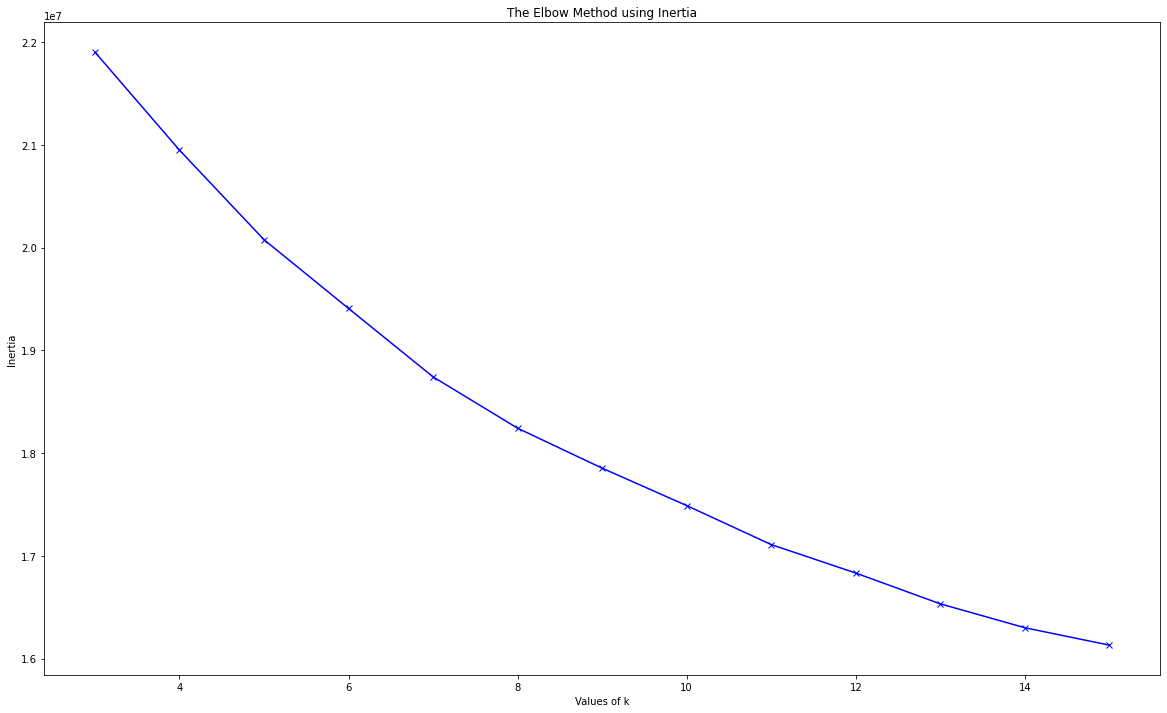

In [386]:
inertias = [] 
mapping = {} 
K = range(3,16)

for k in K:
    # build and fit model
    kmean = KMeans(n_clusters=k, random_state=SEED).fit(azdias_pc)
    kmean = kmean.fit(azdias_pc)
    
    inertias.append(kmean.inertia_) 

    mapping[k] = kmean.inertia_
    
fig = plt.figure(figsize=(20, 12))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of k') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

   Cluster  Population  Customers  Population Percentage  Customers Percentage
0        0      106564       1442              14.453511              1.074147
1        1       96686      10515              13.113736              7.832636
2        2       94920      57347              12.874209             42.717846
3        3       77054       5262              10.451004              3.919670
4        4       85011       1251              11.530230              0.931871
5        5       62799       1988               8.517567              1.480863
6        6       86569      39985              11.741545             29.784873
7        7      127685      16456              17.318199             12.258093

CLUSTER 0 contains about 1.0% of customers
Customers are underrepresented in this cluster 


CLUSTER 1 contains about 8.0% of customers
Customers are underrepresented in this cluster 


CLUSTER 2 contains about 43.0% of customers
Customers are overrepresented in this cluster


CLUSTER 3 

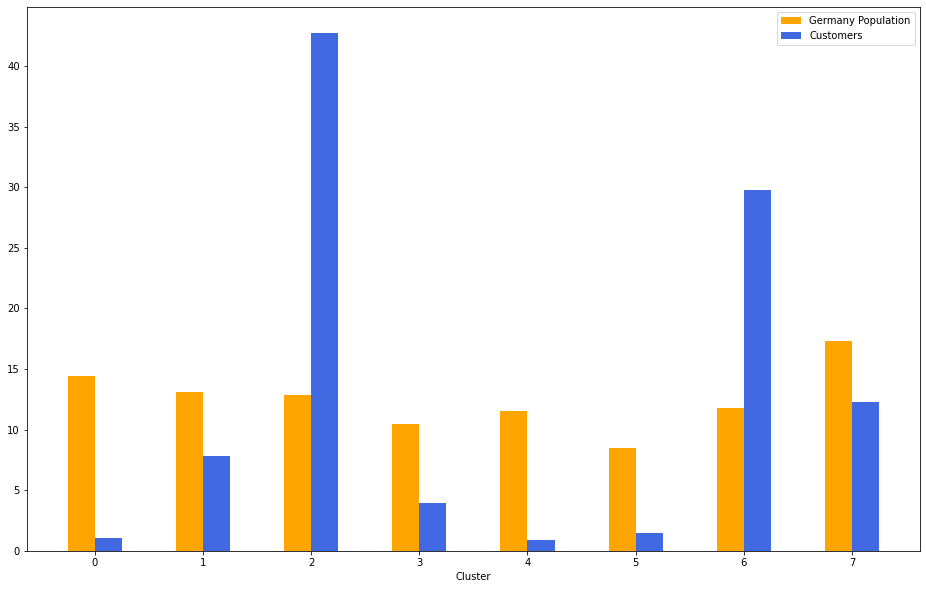

In [383]:
#Train clustering model with k=8
kmeans = MiniBatchKMeans(n_clusters=8, batch_size=100, random_state = SEED)
#kmeans = KMeans(n_clusters=8,random_state = SEED)
clusters_model = kmeans.fit(azdias_pc)

#Predict the cluster of each sample using the above model
azdias_clusters = kmeans.predict(azdias_pc)
customers_clusters = kmeans.predict(customers_pc)

#Create a dataframe with number of people and customers on each cluster
cluster_distribution = pd.DataFrame([])
cluster_distribution['Population'] = pd.value_counts(azdias_clusters).sort_index()
cluster_distribution['Customers'] = pd.value_counts(customers_clusters).sort_index()
cluster_distribution.reset_index(inplace=True)
cluster_distribution.rename(columns={"index":"Cluster"}, inplace=True)

m_azdias = len(azdias_clusters)
m_customers = len(customers_clusters)

cluster_distribution['Population Percentage']  = (cluster_distribution['Population']/m_azdias)*100
cluster_distribution['Customers Percentage'] = (cluster_distribution['Customers']/m_customers)*100


#Bar graph with general population and customers distribution on clusters
bar_w = .25
x1 = np.arange(8)
x2 = [x + bar_w for x in x1]
plt.figure(figsize = (16,10))
plt.bar(x1, cluster_distribution['Population Percentage'].values, color = 'orange', width = bar_w, label = 'Germany Population')
plt.bar(x2, cluster_distribution['Customers Percentage'].values, color = 'royalblue', width = bar_w, label = 'Customers')
plt.xlabel('Cluster')
plt.xticks([r + bar_w/2 for r in range(8)],['0', '1', '2', '3', '4', '5', '6', '7'])
plt.legend()
plt.show;

#table with summary of distributions
print(cluster_distribution)
interesting_clusters = []
for i in cluster_distribution.Cluster.values:
    #print('CLUSTER '+str(i)+':')
    number = cluster_distribution['Customers Percentage'].loc[i]
    print('\n\033[1mCLUSTER ' + str(i) + '\033[0m contains about {}% of customers'.format(round(number)))
    if number > cluster_distribution['Population Percentage'].loc[i]:
        interesting_clusters.append(i)
        print('Customers are \033[1m' + 'overrepresented' '\033[0m in this cluster\n')
    else:
        print ('Customers are \033[1m' + 'underrepresented' '\033[0m in this cluster \n')
        
print('Interesting clusters are:') 
print(interesting_clusters)

# Customer Segmentation Report

In this section we use the clusters obtained and describe the relationship between the demographics of the company's existing customers and the general population of Germany. We aim to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

As we saw in the previous section, the clusters of main interest are 2 and 6 as customers are overrepresented in comparision to Germany's population.

In [401]:
#create data frame with centers of clusters 2 and 6
clusters_centers = pd.DataFrame(kmeans.cluster_centers_[[2,6],:], index = [2, 6])
clusters_centers.columns = ['PC'+str(k) for k in range(1,23)]
clusters_centers.index.name = 'Center of Cluster'
clusters_centers.sort_index(ascending = True)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22
Center of Cluster,,,,,,,,,,,,,,,,,,,,,
2,4.362250,0.766930,-0.195851,0.242816,0.463780,-0.104894,0.045819,-0.065595,0.003195,-0.021134,...,0.000732,0.047632,-0.010432,0.010938,-0.138482,-0.109633,0.020313,-0.007181,-0.033231,-0.000402
6,1.690484,-1.825291,0.863002,-1.141151,-0.613119,1.135035,-0.611994,0.112780,0.033452,0.120858,...,0.067897,-0.062150,-0.108420,0.007689,0.032754,0.096444,-0.036079,-0.026290,-0.038868,-0.037812


We use skitlearn's **inverse_transform** function to express the centers of these clusters in the original features. Note that we used the first 22 principal components in our cluster analysis so we'll need to augment the dimension of these rows to the original 280 by padding them with zeros.

In [403]:
#pad the centers principal components with zeros for the remaining principal components
for l in range(23, 46):
    clusters_centers['PC'+str(l)] = 0

# Use inverse PCA and scaling to center values as original variables
centers_df = azdias_pca.inverse_transform(azdias_pca.inverse_transform(clusters_centers))
centers_df = pd.DataFrame(centers_df, columns=azdias_selected.columns, index = ['cluster_2','cluster_6'])
centers_df

,D19_KONSUMTYP,PRAEGENDE_JUGENDJAHRE,FINANZ_ANLEGER,FINANZ_VORSORGER,LP_LEBENSPHASE_FEIN,FINANZ_MINIMALIST,KKK,ONLINE_AFFINITAET,LP_LEBENSPHASE_GROB,REGIOTYP,...,KBA13_BMW,LP_FAMILIE_FEIN,KBA13_HERST_BMW_BENZ,D19_GESAMT_ONLINE_QUOTE_12,SEMIO_RAT,D19_VERSICHERUNGEN,D19_BILDUNG,D19_HAUS_DEKO,SEMIO_LUST,LP_FAMILIE_GROB
cluster_2,1.036056,-0.896547,0.986355,-0.853053,-0.499597,-0.358539,-0.443167,-1.202249,-0.404833,0.233822,...,-0.104378,-0.218041,-0.630669,-0.948510,0.596660,-0.190388,-0.013868,-0.174577,-1.187727,0.436965
cluster_6,0.322164,0.581419,0.500680,0.233773,-0.424003,-0.008757,-0.212017,-0.198288,-0.062212,-0.424836,...,-0.091171,-0.350355,-0.776692,-0.441225,-0.316314,-0.499266,-0.489977,-0.279264,-0.518021,-0.149188


Now we take a look at which features are weighted more heavily in the first 5 principal components. For this and for future analysis it will be useful to create a dataframe with the attributes in azdias and their corresponding description.

In [409]:
clean_azdias = pd.read_csv('clean_azdias.csv')
clean_customers = pd.read_csv('clean_customers.csv')

In [412]:
#Load attributes info and drop unnecessary columns
attributes_desc = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1).drop(['Unnamed: 0', 'Value', 'Meaning'], axis=1)
attributes_desc.dropna(inplace = True)

#Small modification on the name of some features in description so that they appear in 
attributes_desc['Attribute'] = [attribute[:-3] if attribute[-3:] == '_RZ' else attribute for attribute in attributes_desc.Attribute] 

#Drop those that do not appear on azdias
azdias_attributes_desc = attributes_desc.loc[attributes_desc['Attribute'].isin(clean_azdias.columns)]

#Create a dataframe with azdias attributes in one column
azdias_attributes_df = pd.DataFrame(clean_azdias.columns.values, columns = ['Attribute'])

#Left merge azdias_attributes_df with azdias_attributes_desc to get azdias attributes with their description
azdias_attributes_description = azdias_attributes_df.merge(azdias_attributes_desc, on = 'Attribute', how='left')

azdias_attributes_description.head(10)

,Attribute,Description
0,ALTER_HH,main age within the household
1,ANZ_HAUSHALTE_AKTIV,number of households in the building
2,ANZ_HH_TITEL,number of academic title holder in building
3,ANZ_PERSONEN,number of adult persons in the household
4,ANZ_TITEL,number of professional title holder in household
5,BALLRAUM,distance to next urban centre
6,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup
7,CJT_GESAMTTYP,customer journey typology
8,D19_BANKEN_DIREKT,transactional activity based on the product gr...
9,D19_BANKEN_GROSS,transactional activity based on the product gr...


## Cluster 2

This is the most interesting cluster since it shows the largest concentration of custormers. Its center can be used to identify segments of the population that best describe the core customer base of the company.

In [405]:
from scipy import stats

In [419]:
for col in azdias_selected.columns:
    #Compute the percentile rank of each feature of center 2 relative to the overall population
    percentile = stats.percentileofscore(azdias_selected[col].values,centers_df.loc['cluster_2'][col])
    if percentile>80:
        description = azdias_attributes_description[azdias_attributes_description['Attribute'] == col]['Description'].item()
        print('{}, {}'.format(col, description))
        print('\n')

FINANZ_ANLEGER, financial typology: investor


NATIONALITAET_KZ, nationaltity (scored by prename analysis)


D19_SAMMELARTIKEL, transactional activity based on the product group COLLECTABLE ITEMS


ANZ_HH_TITEL, number of academic title holder in building


WOHNDAUER_2008, length of residence


D19_BEKLEIDUNG_GEH, transactional activity based on the product group LUXURY CLOTHING


D19_BANKEN_DIREKT, transactional activity based on the product group DIRECT BANKS


D19_LOTTO, transactional activity based on the product group LOTTO


D19_SCHUHE, transactional activity based on the product group SHOES


D19_BILDUNG, transactional activity based on the product group EDUCATION




Let's now inspect which features of center of cluster 2 that have very low percentile rank.

In [422]:
for col in azdias_selected.columns:
    #Compute the percentile rank of each feature of center 2 relative to the overall population
    percentile = stats.percentileofscore(azdias_selected[col].values,centers_df.loc['cluster_2'][col])
    if percentile<20:
        description = azdias_attributes_description[azdias_attributes_description['Attribute'] == col]['Description'].item()
        print('{}, {}'.format(col, description))
        print('\n')

ONLINE_AFFINITAET, online affinity


OST_WEST_KZ_O, nan


D19_GESAMT_ONLINE_QUOTE_12, amount of online transactions within all transactions in the complete file 




## Cluster 6

The following are the features of the average person in Cluster 6 that have a value greater than most of Germany's population.

In [424]:
for col in azdias_selected.columns:
    #Compute the percentile rank of each feature of center 2 relative to the overall population
    percentile = stats.percentileofscore(azdias_selected[col].values,centers_df.loc['cluster_6'][col])
    if percentile>75:
        description = azdias_attributes_description[azdias_attributes_description['Attribute'] == col]['Description'].item()
        print('{}, {}'.format(col, description))
        print('\n')

OST_WEST_KZ_O, nan


GREEN_AVANTGARDE, Green avantgarde


D19_BANKEN_DIREKT, transactional activity based on the product group DIRECT BANKS


D19_LOTTO, transactional activity based on the product group LOTTO


D19_SCHUHE, transactional activity based on the product group SHOES


D19_HAUS_DEKO, transactional activity based on the product group HOUSE DECORATION




In [425]:
for col in azdias_selected.columns:
    #Compute the percentile rank of each feature of center 2 relative to the overall population
    percentile = stats.percentileofscore(azdias_selected[col].values,centers_df.loc['cluster_6'][col])
    if percentile<25:
        description = azdias_attributes_description[azdias_attributes_description['Attribute'] == col]['Description'].item()
        print('{}, {}'.format(col, description))
        print('\n')

NATIONALITAET_KZ, nationaltity (scored by prename analysis)


D19_SAMMELARTIKEL, transactional activity based on the product group COLLECTABLE ITEMS


ANZ_HH_TITEL, number of academic title holder in building


OST_WEST_KZ_W, nan


WOHNDAUER_2008, length of residence


SEMIO_KULT, affinity indicating in what way the person is cultural minded


D19_BEKLEIDUNG_GEH, transactional activity based on the product group LUXURY CLOTHING


KBA13_HERST_BMW_BENZ, share of BMW & Mercedes Benz within the PLZ8


D19_BILDUNG, transactional activity based on the product group EDUCATION




# Supervised Learning Model

Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43,000 data rows. Later we will verify our model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. At the end, we'll create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [47]:
#load data sets again
azdias_raw = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [366]:
def processed_supervised(azdias_raw, customers, attributes):
    """Cleans and processes customer information for supervised models
    Args: azdias_raw - general population data set 
          customers - customers data set
          attributes - features information
    Returns: clean_customers - clean version of customers without unnecessary columns (LNR,'CAMEO_DEU_2015','CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'LNR','OST_WEST_KZ' ), but no rows or large percentage of nan cols are dropped

    """
    n_cols = customers.shape[1]
    labels = []
    #save labels
    if 'RESPONSE' in customers.columns:
        labels = customers['RESPONSE']
    _ , clean_customers = clean_data.clean_data(azdias_raw, customers, attributes, 1, n_cols)
    missing_cols = set(customers.columns) - set(clean_customers.columns)
    cols_to_add  = set(customers.columns)-set(clean_customers)-set(customers[missing_cols].select_dtypes(np.dtype("O")).columns)-{'LNR'}
    df_to_concat = customers[cols_to_add]
    clean_customers = pd.concat([clean_customers, df_to_concat], axis = 1)
    if 'RESPONSE' in clean_customers.columns:
        clean_customers.drop(['RESPONSE'], axis = 1,  inplace = True)
    #impute values with the column mean
    clean_customers = clean_data.mean_imputer(clean_customers)
    #standarize X-columns of customers
    customers_scaler = StandardScaler()
    customers_scaler.fit_transform(clean_customers)
    processed_customers = pd.DataFrame(customers_scaler.transform(clean_customers), columns= clean_customers.columns)
    return processed_customers, labels

In [94]:
mailout_train_processed, labels  = process_supervised(azdias_raw, mailout_train, attributes)

In [98]:
mailout_train_processed.to_csv('mailout_train_processed.csv', index=False)

## Feature Engineering

In [126]:
mailout_train_processed = pd.read_csv('mailout_train_processed.csv')

In [129]:
def add_cluster_feature(customers, pc = azdias_pc, pca = azdias_pca, kmeans = kmeans):
    """Adds cluster column to clean customer data. 
    Args: customers - cleaned dataframe of customers
          azdias - cleaned general pop dataframe
          pca - azdias pca model
          kmeans - azdias kmeans model
    Returns: customers with cluster encoding feature column 

    """
    customers_copy = customers.copy()
    #select columns of azdias_selected
    customers_selected = customers[azdias_selected.columns]
    #project customers to azdias pc
    customers_pc= azdias_pca.transform(customers_selected)
    #select the first components
    n = azdias_pc.shape[1]
    customers_pc = pd.DataFrame(customers_pc).iloc[:,:n]
    #find cluster of each row
    customers_clusters = kmeans.predict(customers_pc)
    #add column of clusters to each row
    customers_copy['CLUSTERS'] = customers_clusters
    return customers_copy

In [143]:
mailout_train_cluster = add_cluster_feature(mailout_train_processed)

In [144]:
mailout_train_cluster

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CJT_TYP_4,SOHO_KZ,VERDICHTUNGSRAUM,CJT_KATALOGNUTZER,KBA13_CCM_1401_2500,CJT_TYP_6,KOMBIALTER,HH_DELTA_FLAG,KBA13_ANTG2,CLUSTERS
0,0.651811,-0.410526,0.604874,-0.145,-0.818214,-0.10013,0.374223,0.016142,-0.745525,9.408601e-16,...,0.590056,-0.10795,-0.061017,0.770747,0.028531,0.590697,-0.282441,-0.437076,1.562176,7
1,-1.218983,0.487562,-0.416145,-0.145,-0.013746,-0.10013,0.374223,0.016142,-0.745525,-2.462024e+00,...,-1.304644,-0.10795,-0.584772,-1.324129,1.193757,-0.435855,-0.282441,-0.437076,-0.830706,6
2,-1.218983,-0.230909,-0.489075,0.000,-1.622682,-0.10013,-1.639828,-1.356478,0.389014,9.408601e-16,...,0.590056,-0.10795,0.724616,0.770747,1.193757,0.590697,-0.282441,0.000000,-2.027148,6
3,0.651811,-0.769762,-0.197355,-0.145,-0.013746,-0.10013,-1.136315,-1.356478,-0.745525,9.408601e-16,...,0.590056,-0.10795,0.069922,0.770747,-2.301921,-0.435855,-0.282441,-0.437076,-0.830706,7
4,0.651811,-0.230909,3.376210,-0.145,-0.818214,-0.10013,-0.129290,0.931221,1.523553,9.408601e-16,...,0.590056,-0.10795,-0.061017,0.770747,1.193757,0.590697,-0.282441,-0.437076,-0.830706,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,0.651811,-1.847469,-0.416145,-0.145,-0.013746,-0.10013,-1.136315,-0.898938,-0.178255,9.408601e-16,...,0.590056,-0.10795,-0.061017,-2.022421,-1.136695,-0.435855,-0.282441,2.953193,0.365735,2
42958,0.000000,-1.847469,-0.416145,-0.145,-0.013746,-0.10013,0.877736,0.473681,-0.178255,9.408601e-16,...,-0.357294,-0.10795,-0.584772,-0.625837,2.358983,0.590697,-0.772634,-0.437076,-0.830706,2
42959,-1.218983,1.026416,-0.343215,-0.145,0.790723,-0.10013,0.877736,-0.441398,0.956284,9.408601e-16,...,0.590056,-0.10795,-0.584772,0.770747,0.028531,0.590697,-0.282441,-0.437076,-0.830706,2
42960,0.651811,1.385651,-0.270285,-0.145,0.790723,-0.10013,0.877736,1.388761,0.956284,1.775233e+00,...,-1.304644,-0.10795,-0.584772,-0.625837,-1.136695,0.590697,-0.282441,-0.437076,1.562176,3


In [133]:
def binary_cluster_info(customers, dictionary):
    customers.CLUSTERS.replace(dictionary, inplace = True)
    return customers

In [66]:
interesting_clusters

[2, 6]

In [145]:
engineered_mailout_train = binary_cluster_info(mailout_train_cluster, {0:1, 1:0, 2:1, 3:0, 4:0, 5:0, 6:1, 7:0})

In [146]:
engineered_mailout_train

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,CJT_TYP_4,SOHO_KZ,VERDICHTUNGSRAUM,CJT_KATALOGNUTZER,KBA13_CCM_1401_2500,CJT_TYP_6,KOMBIALTER,HH_DELTA_FLAG,KBA13_ANTG2,CLUSTERS
0,0.651811,-0.410526,0.604874,-0.145,-0.818214,-0.10013,0.374223,0.016142,-0.745525,9.408601e-16,...,0.590056,-0.10795,-0.061017,0.770747,0.028531,0.590697,-0.282441,-0.437076,1.562176,0
1,-1.218983,0.487562,-0.416145,-0.145,-0.013746,-0.10013,0.374223,0.016142,-0.745525,-2.462024e+00,...,-1.304644,-0.10795,-0.584772,-1.324129,1.193757,-0.435855,-0.282441,-0.437076,-0.830706,1
2,-1.218983,-0.230909,-0.489075,0.000,-1.622682,-0.10013,-1.639828,-1.356478,0.389014,9.408601e-16,...,0.590056,-0.10795,0.724616,0.770747,1.193757,0.590697,-0.282441,0.000000,-2.027148,1
3,0.651811,-0.769762,-0.197355,-0.145,-0.013746,-0.10013,-1.136315,-1.356478,-0.745525,9.408601e-16,...,0.590056,-0.10795,0.069922,0.770747,-2.301921,-0.435855,-0.282441,-0.437076,-0.830706,0
4,0.651811,-0.230909,3.376210,-0.145,-0.818214,-0.10013,-0.129290,0.931221,1.523553,9.408601e-16,...,0.590056,-0.10795,-0.061017,0.770747,1.193757,0.590697,-0.282441,-0.437076,-0.830706,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,0.651811,-1.847469,-0.416145,-0.145,-0.013746,-0.10013,-1.136315,-0.898938,-0.178255,9.408601e-16,...,0.590056,-0.10795,-0.061017,-2.022421,-1.136695,-0.435855,-0.282441,2.953193,0.365735,1
42958,0.000000,-1.847469,-0.416145,-0.145,-0.013746,-0.10013,0.877736,0.473681,-0.178255,9.408601e-16,...,-0.357294,-0.10795,-0.584772,-0.625837,2.358983,0.590697,-0.772634,-0.437076,-0.830706,1
42959,-1.218983,1.026416,-0.343215,-0.145,0.790723,-0.10013,0.877736,-0.441398,0.956284,9.408601e-16,...,0.590056,-0.10795,-0.584772,0.770747,0.028531,0.590697,-0.282441,-0.437076,-0.830706,1
42960,0.651811,1.385651,-0.270285,-0.145,0.790723,-0.10013,0.877736,1.388761,0.956284,1.775233e+00,...,-1.304644,-0.10795,-0.584772,-0.625837,-1.136695,0.590697,-0.282441,-0.437076,1.562176,0


## Feature Selection

In [147]:
from sklearn.feature_selection import SelectKBest

In [152]:
engineered_mailout_train.shape

(42962, 363)

In [234]:
selector = SelectKBest(k = 55)
X_new = selector.fit_transform(engineered_mailout_train, labels)
selected_features = engineered_mailout_train.columns[selector.get_support(indices = True)]
print(selected_features)

Index(['ALTER_HH', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_DIREKT',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TIERARTIKEL', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'HH_EINKOMMEN_SCORE', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_KRSZUL',
       'KBA05_KW3', 'KBA05_MOD1', 'KBA05_SEG6', 'KBA05_VORB0', 'KBA05_ZUL4',
       'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_FIAT', 'KBA13_HALTER_25',
       'KBA13_HALTER_65', 'KBA13_HERST_BMW_BENZ', 'KBA13_KMH_110',
       'KBA13_KMH_140_210', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KW_121',
       'KBA13_KW_30', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_WOHNMOBILE',
       'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6',
       'PRAEGENDE_JUGENDJAHRE', 'SEMIO_LUST', 'W_KEIT_KIND_HH', 'ZABEOTYP',
       'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'CJT_TYP_3', 'CJT_TYP_5',
       'ALTERSKATEGORIE_FEIN', 'KBA13_GBZ', 'D19_SOZIALES',
       'D19_KONSUMTYP_MAX', 'CJT_TYP_2', 'RT_SCHNAEPPCHEN', 'RT_KEIN_ANREIZ',
       'AK

## Models

In [235]:
mailout_train_X = engineered_mailout_train[selected_features]

### Logistic Regression Benchmark

In [236]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, labels, stratify = labels, test_size=0.2)
logistic_reg = LogisticRegression(max_iter = 1000, random_state =SEED, class_weight = 'balanced', multi_class = 'ovr')
logistic_reg.fit(X_train, y_train)
predictions = logistic_reg.predict_proba(X_val)[:,1]
print('Baseline AUROC: ', roc_auc_score(y_val, predictions))

Baseline AUROC:  0.7311626438659793


### Other Models

In [203]:
def roc_time(model, X_train, y_train, X_test, y_test):
    "Fits model, predicts and outputs AUROC score and time it took"
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elap = end - start
    return roc_score, time_elap

In [306]:
gbc = GradientBoostingClassifier(random_state=SEED)
roc, time_ = roc_time(gbc, X_train, y_train, X_val, y_val)
print('AUROCSCORE: {}, Time: {}'.format( roc, time_))

AUROCSCORE: 0.7339149109292569, Time: 8.385370969772339


## Grid Search

GRADIENT BOOST

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.0s finished


Best Score:  0.7672968359158375
Best Params:  {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 15, 'min_samples_leaf': 55, 'min_samples_split': 500, 'n_estimators': 220, 'subsample': 0.9}


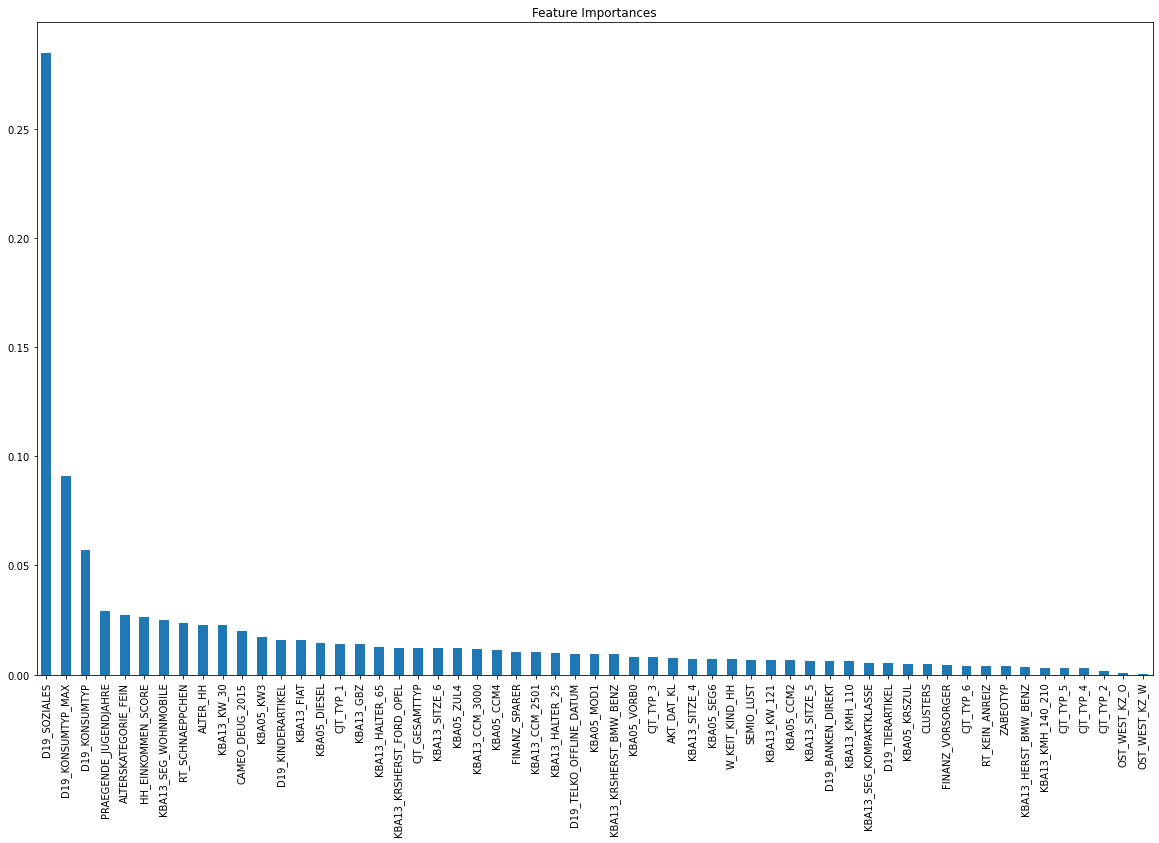

In [327]:
grad_param_grid = {"learning_rate": [0.05],
                   "n_estimators" : [220],
                   "max_depth" : [3],
                   "min_samples_split" : [500],
                   "min_samples_leaf": [55],
                   "max_features": [15],
                   'subsample':[0.9]
                   
                  }


gradient_boost_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state = SEED), param_grid = grad_param_grid, scoring = "roc_auc", n_jobs = -1, verbose=1)

gradient_boost_grid.fit(X_train, y_train)

best_gradient_boost = gradient_boost_grid.best_estimator_

print("Best Score: ", gradient_boost_grid.best_score_)
print("Best Params: ", gradient_boost_grid.best_params_)

feat_imp = pd.Series(best_gradient_boost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize = (20,12))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 178.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 209.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 251.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 281.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 891.0min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 897.7min finished


Best Score:  0.7777009366359928
Best Params:  {'learning_rate': 0.005, 'max_depth': 2, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 600, 'n_estimators': 1200, 'subsample': 0.9}


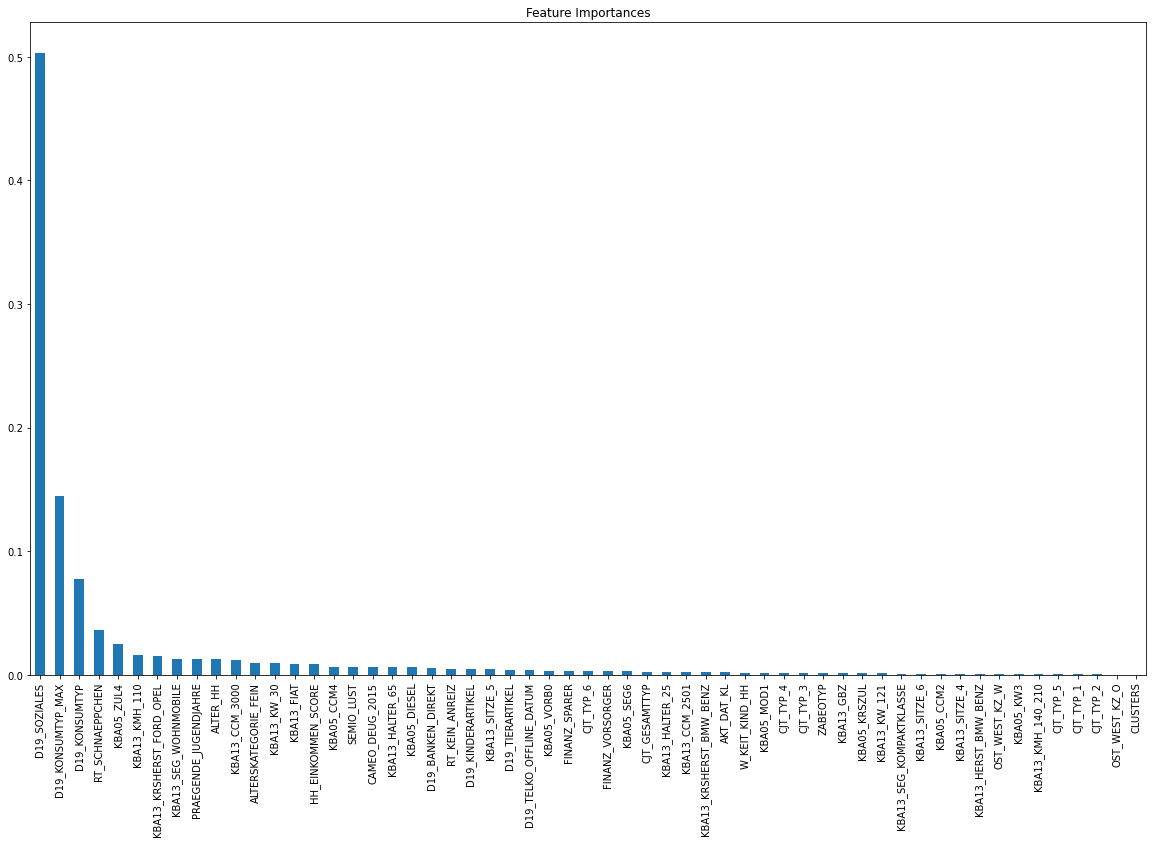

In [346]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, labels, stratify = labels, test_size=0.2)
grad_param_grid = {"learning_rate": [0.01, 0.005],
                   "n_estimators" : [300, 400, 600, 1200],
                   "max_depth" : [2, 3, 5],
                   "min_samples_split" : [400, 500, 600],
                   "min_samples_leaf": [50,55, 60],
                   "max_features": [10, 15, 20],
                   'subsample':[0.9]
                   
                  }


gradient_boost_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state = SEED), param_grid = grad_param_grid, scoring = "roc_auc", n_jobs = -1, verbose=1)

gradient_boost_grid.fit(X_train, y_train)

best_gradient_boost = gradient_boost_grid.best_estimator_

print("Best Score: ", gradient_boost_grid.best_score_)
print("Best Params: ", gradient_boost_grid.best_params_)

feat_imp = pd.Series(best_gradient_boost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize = (20,12));

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 117.7min finished


Best Score:  0.767119831660581
Best Params:  {'learning_rate': 0.005, 'max_depth': 2, 'max_features': 30, 'min_samples_leaf': 45, 'min_samples_split': 600, 'n_estimators': 1200, 'subsample': 0.9}


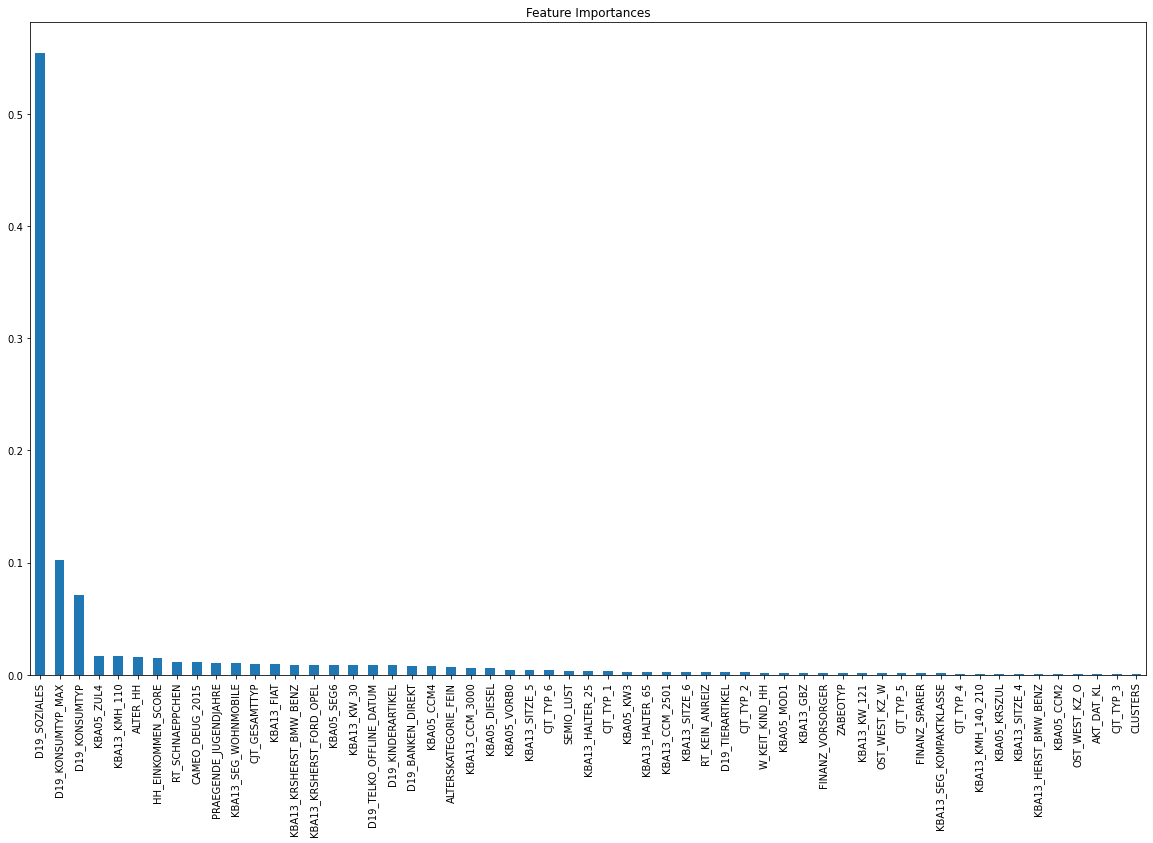

In [347]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_X, labels, stratify = labels, test_size=0.2)
grad_param_grid = {"learning_rate": [0.005, 0.001],
                   "n_estimators" : [1200, 2200],
                   "max_depth" : [2, 3],
                   "min_samples_split" : [600, 700],
                   "min_samples_leaf": [45,50],
                   "max_features": [20, 30],
                   'subsample':[0.9]
                   
                  }


gradient_boost_grid = GridSearchCV(estimator = GradientBoostingClassifier(random_state = SEED), param_grid = grad_param_grid, scoring = "roc_auc", n_jobs = -1, verbose=1)

gradient_boost_grid.fit(X_train, y_train)

best_gradient_boost = gradient_boost_grid.best_estimator_

print("Best Score: ", gradient_boost_grid.best_score_)
print("Best Params: ", gradient_boost_grid.best_params_)

feat_imp = pd.Series(best_gradient_boost.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize = (20,12));

Best Params:  {'learning_rate': 0.005, 'max_depth': 2, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 600, 'n_estimators': 1200, 'subsample': 0.9}

# Kaggle Competition

It's time to test that model in competition through Kaggle.  To entry the competition we need a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. 

The competition uses AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

## Data Processing, Feature Selection and Engineering

In [340]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [358]:
mailout_test.shape

(42833, 366)

In [367]:
#process test set
mailout_test_processed, _ = processed_supervised(azdias_raw, mailout_test, attributes)

In [368]:
mailout_test_processed.shape

(42833, 362)

In [369]:
mailout_test_processed.to_csv('mailout_test_processed.csv', index=False)
#mailout_test_processed = pd.read_csv('mailout_test_processed.csv')

In [370]:
#add cluster engineered feature
mailout_test_cluster = add_cluster_feature(mailout_test_processed)
engineered_mailout_test = binary_cluster_info(mailout_test_cluster, {0:1, 1:0, 2:1, 3:0, 4:0, 5:0, 6:1, 7:0})

In [373]:
#select features
mailout_test_X = engineered_mailout_test[selected_features]

In [375]:
mailout_test_X

,ALTER_HH,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_DIREKT,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_TELKO_OFFLINE_DATUM,D19_TIERARTIKEL,FINANZ_SPARER,FINANZ_VORSORGER,...,D19_SOZIALES,D19_KONSUMTYP_MAX,CJT_TYP_2,RT_SCHNAEPPCHEN,RT_KEIN_ANREIZ,AKT_DAT_KL,CJT_TYP_1,CJT_TYP_4,CJT_TYP_6,CLUSTERS
0,-5.788195e-01,-1.357323,0.961990,-0.386287,-0.499004,-0.272807,-1.615250e-15,-0.218962,-0.695186,0.748690,...,-5.069857e-01,-0.808910,-0.221619,0.723175,-0.397448,-0.326023,-1.148806,0.595976,0.590921,1
1,-1.829544e+00,0.014861,-1.325350,-0.386287,-0.499004,-0.272807,-1.615250e-15,-0.218962,-0.695186,0.748690,...,-5.069857e-01,-0.808910,-0.221619,0.723175,-1.215001,-0.326023,-0.402843,0.595976,0.590921,0
2,1.029255e+00,0.929651,-0.753515,-0.386287,-0.499004,2.129389,-1.615250e-15,-0.218962,-0.695186,0.748690,...,-1.237038e+00,1.059177,-0.221619,0.723175,-0.397448,4.700435,-0.402843,0.595976,0.590921,1
3,-1.829544e+00,-1.357323,0.390155,-0.386287,-0.499004,2.129389,-1.615250e-15,-0.218962,-0.695186,-0.265595,...,-1.237038e+00,1.059177,-0.947776,-0.948933,-1.215001,3.443821,-0.402843,0.595976,0.590921,0
4,1.922630e+00,0.014861,1.533825,0.711790,1.636841,-1.073539,9.368889e-01,5.412493,-0.695186,0.748690,...,-1.237038e+00,-1.120258,-0.221619,-1.784987,0.420105,-0.326023,0.343120,-0.352606,-1.462228,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,-3.173904e-16,0.000000,1.533825,-0.386287,-0.499004,0.000000,-1.615250e-15,-0.218962,1.733599,-1.279879,...,1.621041e-16,1.370525,1.956851,0.723175,1.237657,0.000000,1.835045,0.595976,0.590921,1
42829,-4.279470e-02,0.472256,-0.753515,-0.386287,-0.499004,-0.272807,-1.615250e-15,-0.218962,-0.695186,0.748690,...,9.531182e-01,1.059177,-0.947776,0.723175,0.420105,-0.326023,-1.148806,0.595976,0.590921,1
42830,1.029255e+00,-0.442533,-0.181680,2.907943,2.064010,-1.073539,-1.615250e-15,-0.218962,0.114409,-0.265595,...,-5.069857e-01,-0.808910,-0.221619,-1.784987,1.237657,-0.326023,0.343120,-1.301188,-1.462228,1
42831,-1.829544e+00,-1.814717,0.961990,-0.386287,-0.499004,0.928291,-1.615250e-15,-0.218962,0.114409,-0.265595,...,-5.069857e-01,-0.186214,-0.221619,-0.948933,0.420105,-0.326023,0.343120,-0.352606,-0.435653,1


## Model Prediction

In [353]:
best_gradient_boost.fit(mailout_train_X, labels)

GradientBoostingClassifier(learning_rate=0.005, max_depth=2, max_features=30,
                           min_samples_leaf=45, min_samples_split=600,
                           n_estimators=1200, random_state=42, subsample=0.9)

In [374]:
gbc_test_pred = best_gradient_boost.predict_proba(mailout_test_X)[:, 1]

In [380]:
kaggle_gbc = pd.DataFrame(index = mailout_test.LNR, data = gbc_test_pred)
kaggle_gbc.rename(columns={0: "RESPONSE"}, inplace=True)

In [381]:
kaggle_gbc

,RESPONSE
LNR,
1754,0.038849
1770,0.036247
1465,0.004414
1470,0.003830
1478,0.005043
...,...
67615,0.011619
67938,0.003827
67942,0.017611


In [382]:
kaggle_gbc.to_csv('kaggle_submission.csv')